In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'daily-temperature-of-major-cities:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F694560%2F1215964%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240401%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240401T133727Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7255cf590c9746e2f417ce05a33394b95ee59ec870437228c02f32a8e5aa9dd33d6d7205a4766419a8db2f3c88055ad1c5608415fd40b051f439c8e45e2370a7021844bd20477649e832c977e7fbd4ae4831efc7ae4da7dac89a6b5315051849f3a812517af243a2b7e5b415d362f610891ad82fee5edbb5eee4d7d18605fd829cf00921d722e9e4344373ed2870a91aeec9a1067ec983ae5610af4486d7d9a13460917f147e0708fec2ed40385856e52a691be66cad0684ef249dddd25feb14d2bdb37363388c3bc6ecb36f2546db6598ece6c095b6ad6387ce6e3ea3fd9023a0121357e6c1c90483c3e38bbdee5747d38d60770c975b7759492678bcafd99c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 13523007 bytes downloaded
Downloaded and uncompressed: daily-temperature-of-major-cities
Data source import complete.


# Introduction

In this notebook, I am creating a tensorflow based timeseries forecasting model using CNN & LSTM.

## Acknowledgments:
This notebook is inspired by the course 4 of TensorFlow in Practice Specialization which is [Sequences, Time Series and Prediction](https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction) by Laurence Moroney.

I used this course to prepare for the tensorflow speciality examination, and I am using the methods and codes that Mr. Moroney used in the course.


## Sections:
1. Introduction
2. Importing and exploring the dataset
3. Imputting missing values
4. Naive forecast
5. Moving average forecast
6. Preparing a pre-fetched tensorflow dataset
7. Creating a CNN-LSTM based model
8. Model metrics
9. Conclusion
10. References


If you find this notebook helpful for you, please upvote!

I always like to import the libraries in the alphabetical order so that is it easy to review when needed

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

# Importing and exploring the dataset

In [3]:
data = pd.read_csv("/kaggle/input/daily-temperature-of-major-cities/city_temperature.csv")
data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


Checking if all the cities has the data for a full range

In [4]:
data['City'].value_counts()

Springfield      18530
Columbus         18530
Portland         18530
Washington DC    18530
Washington       18530
                 ...  
Frankfurt         4136
Flagstaff         3574
Pristina          3427
Yerevan           3226
Bonn              3133
Name: City, Length: 321, dtype: int64

I wanted to develop a timeseries model for a single city. For this purpouse, I am taking the city Chennai (previously known as Madras), from Tamil Nadu, India. The city where I reside.

Chennai generally has only two season. It is hot for almost throughout the year, and rains in November/December months.

In [5]:
chennai = data[data["City"] == "Chennai (Madras)"]
chennai.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
331055,Asia,India,NaN,Chennai (Madras),1,1,1995,72.4
331056,Asia,India,NaN,Chennai (Madras),1,2,1995,73.5
331057,Asia,India,NaN,Chennai (Madras),1,3,1995,72.6
331058,Asia,India,NaN,Chennai (Madras),1,4,1995,75.2
331059,Asia,India,NaN,Chennai (Madras),1,5,1995,74.8


Checking if all the year has complete records

In [6]:
chennai["Year"].value_counts()

2008    366
2000    366
2016    366
2015    366
2004    366
       ... 
2001    365
1999    365
1998    365
1997    365
2020    134
Name: Year, Length: 26, dtype: int64

# Imputing missing values

The dataset has recorded missing values with the number -99. The chennai dataset has missing values close to 29 records.

I will use forward fill method to impute the missing values for the dataset. That is, we will take the previously non missing value and fill it in the place of the missing value.

First replacing -99 with np.nan

In [7]:
"""-99 is put in place of missing values.
We will have to forward fill with the last non missing value before -99
"""
chennai["AvgTemperature"] = np.where(chennai["AvgTemperature"] == -99, np.nan, chennai["AvgTemperature"])
chennai.isnull().sum()

Region               0
Country              0
State             9266
City                 0
Month                0
Day                  0
Year                 0
AvgTemperature      29
dtype: int64

Now using ffill() method to fill the np.nan that we created

In [8]:
chennai["AvgTemperature"] = chennai["AvgTemperature"].ffill()
chennai.isnull().sum()

Region               0
Country              0
State             9266
City                 0
Month                0
Day                  0
Year                 0
AvgTemperature       0
dtype: int64

Since there is no single column that contains the date, creating a new column called Time_steps to combine the year month and date fields

In [9]:
chennai.dtypes
chennai["Time_steps"] = pd.to_datetime((chennai.Year*10000 + chennai.Month*100 + chennai.Day).apply(str),format='%Y%m%d')
chennai.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature,Time_steps
331055,Asia,India,NaN,Chennai (Madras),1,1,1995,72.4,1995-01-01
331056,Asia,India,NaN,Chennai (Madras),1,2,1995,73.5,1995-01-02
331057,Asia,India,NaN,Chennai (Madras),1,3,1995,72.6,1995-01-03
331058,Asia,India,NaN,Chennai (Madras),1,4,1995,75.2,1995-01-04
331059,Asia,India,NaN,Chennai (Madras),1,5,1995,74.8,1995-01-05


In [10]:
def plot_series(time, series, format="-", start=0, end=None):
    """to plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Year")
    plt.ylabel("Temprature")
    plt.grid(True)

Plotting the timeseries for the entire duration

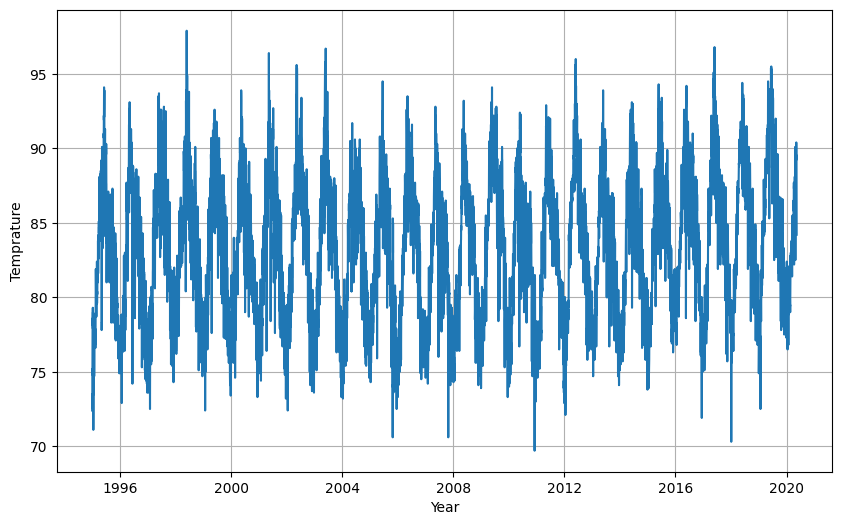

In [11]:
time_step = chennai["Time_steps"].tolist()
temprature = chennai["AvgTemperature"].tolist()

series = np.array(temprature)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

Plotting for recent one year only

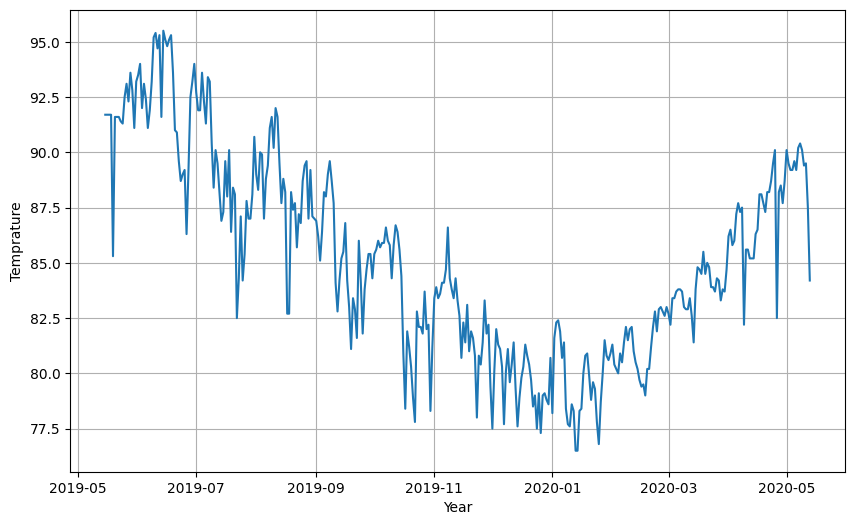

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time[-365:], series[-365:])

There are totally 9,266 records on the dataset. We will keep 8000 records for training (85%) and keep remaining 15% for testing

In [13]:
split_time = 8000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Naive forecast

In naive forecast, we will take the record in month - 1 (the month previously) and assume that it will be carried forward for the next observation also.

In [14]:
naive_forecast = series[split_time - 1:-1]

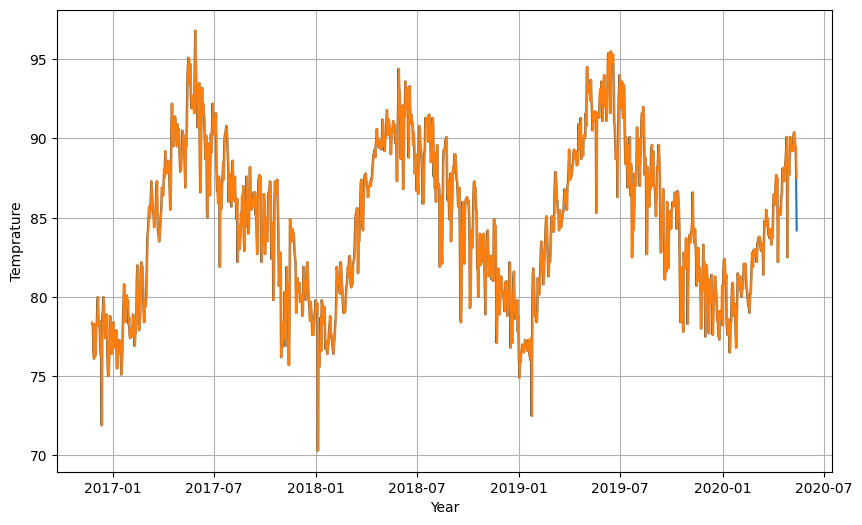

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Since the plot above is so crowded, we will take for a small section of the dataset and visualize it.

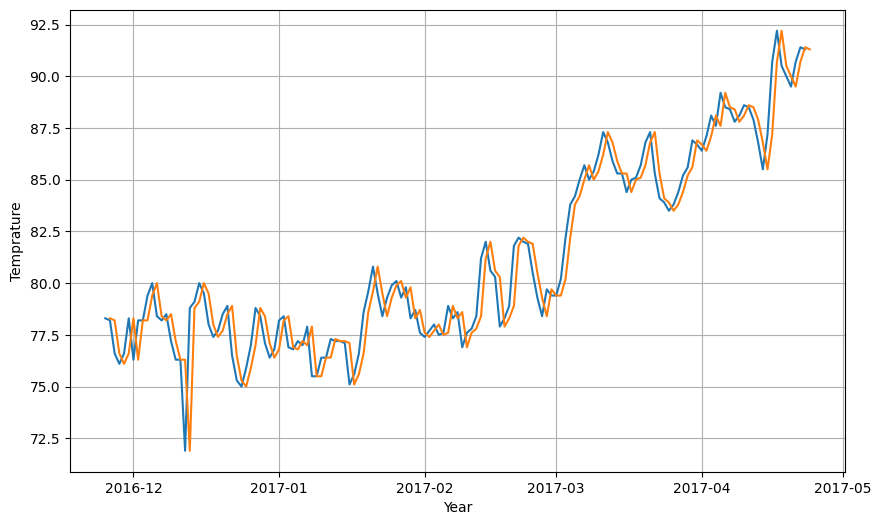

In [16]:
#Zoom in and see only few points
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [17]:
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

2.447661927330174
1.0900473933649284


# Moving average forecast

In moving average forecast, we will take the value of average for the previous window period and take it as the prediction for the next period.

In [18]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

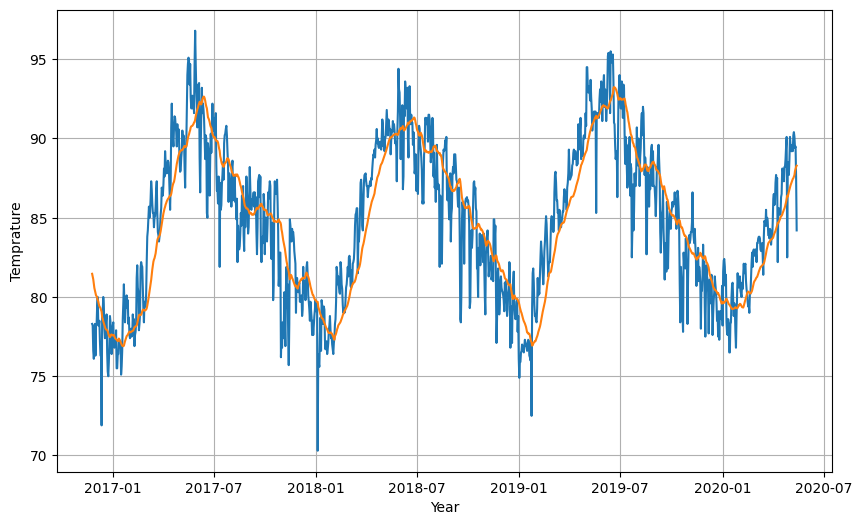

In [19]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [20]:
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

5.45876674565561
1.841850974196946


## Differencing

We will use a technique called differencing to remove the trend and seasonality from the data.
Here we difference the data between what the value was 365 days (1 year back). The differencing should always follow the seasonal pattern.

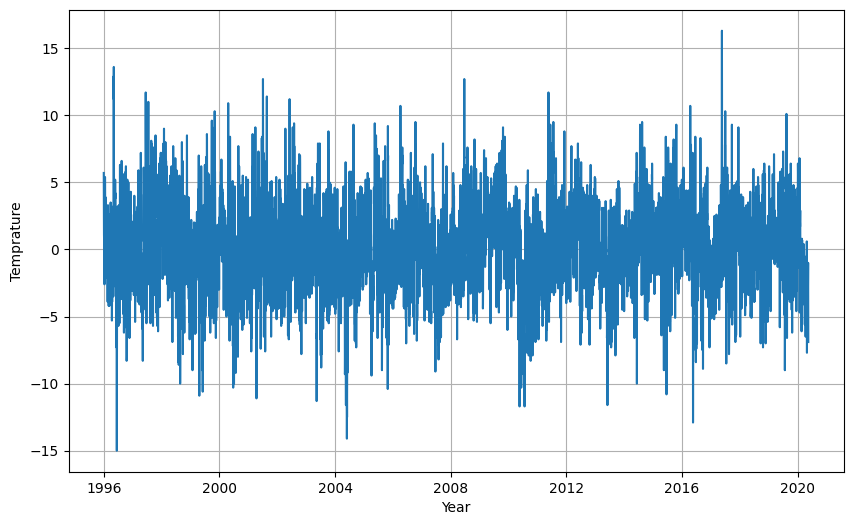

In [21]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

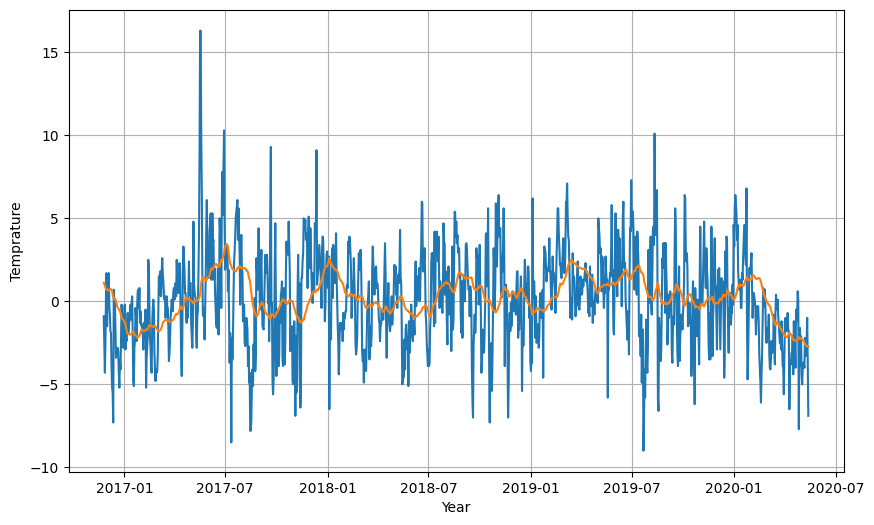

In [22]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

## Restoring trend and seasonality
But these are just the forecast of the differenced timeseries. To get the value for the original timeseries, we have to add back the value of t-365

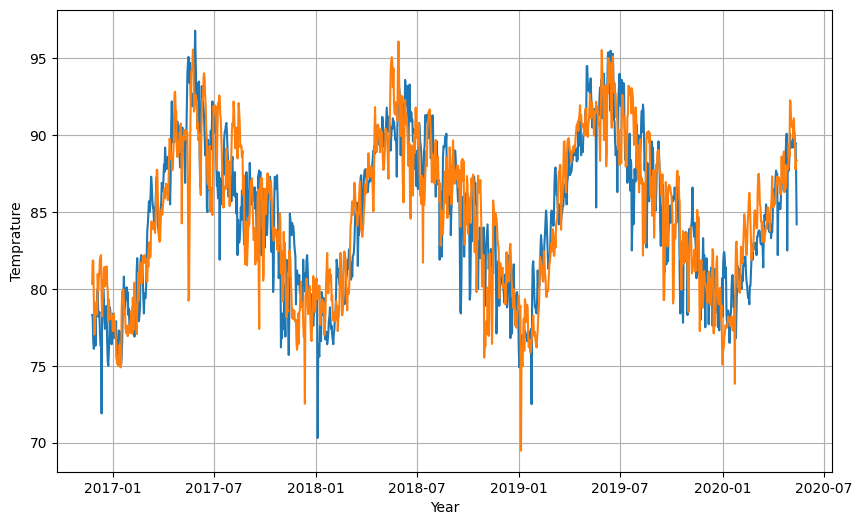

In [23]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [24]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

7.969171658767773
2.1771153238546606


## Smoothing with moving average again

The above plot has a lot of noise. To smooth it again, we do a moving average on that

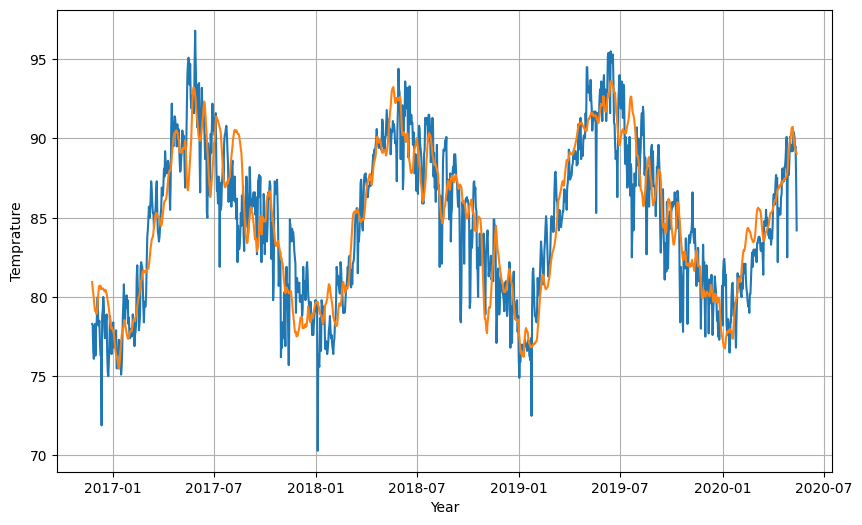

In [25]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [26]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

5.630983364928909
1.8089115323854659


# How to prepare a window dataset?

A window dataset is used in the dataset prepration of the tensorflow. It yields a prefetched dataset with the x and y variables as tensors.

### Step 1: Converting the numpy array into a tensor using tensor_slices

In [27]:
series1 = tf.expand_dims(series, axis=-1)
ds = tf.data.Dataset.from_tensor_slices(series1[:20])
for val in ds:
    print(val.numpy())


[72.4]
[73.5]
[72.6]
[75.2]
[74.8]
[76.4]
[78.4]
[78.6]
[78.1]
[79.3]
[77.9]
[79.]
[73.4]
[76.7]
[73.7]
[77.]
[71.1]
[72.6]
[76.1]
[75.7]


### Step 2: tf window option groups 5 (window size) into a single line

But for the last observations for which there are no observations to group will be kept as remaining as in the outupt of this cell

In [28]:

dataset = ds.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

[72.4] [73.5] [72.6] [75.2] [74.8] 
[73.5] [72.6] [75.2] [74.8] [76.4] 
[72.6] [75.2] [74.8] [76.4] [78.4] 
[75.2] [74.8] [76.4] [78.4] [78.6] 
[74.8] [76.4] [78.4] [78.6] [78.1] 
[76.4] [78.4] [78.6] [78.1] [79.3] 
[78.4] [78.6] [78.1] [79.3] [77.9] 
[78.6] [78.1] [79.3] [77.9] [79.] 
[78.1] [79.3] [77.9] [79.] [73.4] 
[79.3] [77.9] [79.] [73.4] [76.7] 
[77.9] [79.] [73.4] [76.7] [73.7] 
[79.] [73.4] [76.7] [73.7] [77.] 
[73.4] [76.7] [73.7] [77.] [71.1] 
[76.7] [73.7] [77.] [71.1] [72.6] 
[73.7] [77.] [71.1] [72.6] [76.1] 
[77.] [71.1] [72.6] [76.1] [75.7] 
[71.1] [72.6] [76.1] [75.7] 
[72.6] [76.1] [75.7] 
[76.1] [75.7] 
[75.7] 


### Step 3: Drop reminder set to True will drop the variables which are not having the grouping

In [29]:
dataset = ds.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

[72.4] [73.5] [72.6] [75.2] [74.8] 
[73.5] [72.6] [75.2] [74.8] [76.4] 
[72.6] [75.2] [74.8] [76.4] [78.4] 
[75.2] [74.8] [76.4] [78.4] [78.6] 
[74.8] [76.4] [78.4] [78.6] [78.1] 
[76.4] [78.4] [78.6] [78.1] [79.3] 
[78.4] [78.6] [78.1] [79.3] [77.9] 
[78.6] [78.1] [79.3] [77.9] [79.] 
[78.1] [79.3] [77.9] [79.] [73.4] 
[79.3] [77.9] [79.] [73.4] [76.7] 
[77.9] [79.] [73.4] [76.7] [73.7] 
[79.] [73.4] [76.7] [73.7] [77.] 
[73.4] [76.7] [73.7] [77.] [71.1] 
[76.7] [73.7] [77.] [71.1] [72.6] 
[73.7] [77.] [71.1] [72.6] [76.1] 
[77.] [71.1] [72.6] [76.1] [75.7] 


### Step 4: flat map option will group the 5 observation in a single tensor variable

In [30]:
dataset = ds.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[[72.4]
 [73.5]
 [72.6]
 [75.2]
 [74.8]]
[[73.5]
 [72.6]
 [75.2]
 [74.8]
 [76.4]]
[[72.6]
 [75.2]
 [74.8]
 [76.4]
 [78.4]]
[[75.2]
 [74.8]
 [76.4]
 [78.4]
 [78.6]]
[[74.8]
 [76.4]
 [78.4]
 [78.6]
 [78.1]]
[[76.4]
 [78.4]
 [78.6]
 [78.1]
 [79.3]]
[[78.4]
 [78.6]
 [78.1]
 [79.3]
 [77.9]]
[[78.6]
 [78.1]
 [79.3]
 [77.9]
 [79. ]]
[[78.1]
 [79.3]
 [77.9]
 [79. ]
 [73.4]]
[[79.3]
 [77.9]
 [79. ]
 [73.4]
 [76.7]]
[[77.9]
 [79. ]
 [73.4]
 [76.7]
 [73.7]]
[[79. ]
 [73.4]
 [76.7]
 [73.7]
 [77. ]]
[[73.4]
 [76.7]
 [73.7]
 [77. ]
 [71.1]]
[[76.7]
 [73.7]
 [77. ]
 [71.1]
 [72.6]]
[[73.7]
 [77. ]
 [71.1]
 [72.6]
 [76.1]]
[[77. ]
 [71.1]
 [72.6]
 [76.1]
 [75.7]]


### Step 5: map option will split the variables into X and y variables

In [31]:
dataset = ds.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x,y in dataset:
    print(x.numpy(), y.numpy())

[[72.4]
 [73.5]
 [72.6]
 [75.2]] [[74.8]]
[[73.5]
 [72.6]
 [75.2]
 [74.8]] [[76.4]]
[[72.6]
 [75.2]
 [74.8]
 [76.4]] [[78.4]]
[[75.2]
 [74.8]
 [76.4]
 [78.4]] [[78.6]]
[[74.8]
 [76.4]
 [78.4]
 [78.6]] [[78.1]]
[[76.4]
 [78.4]
 [78.6]
 [78.1]] [[79.3]]
[[78.4]
 [78.6]
 [78.1]
 [79.3]] [[77.9]]
[[78.6]
 [78.1]
 [79.3]
 [77.9]] [[79.]]
[[78.1]
 [79.3]
 [77.9]
 [79. ]] [[73.4]]
[[79.3]
 [77.9]
 [79. ]
 [73.4]] [[76.7]]
[[77.9]
 [79. ]
 [73.4]
 [76.7]] [[73.7]]
[[79. ]
 [73.4]
 [76.7]
 [73.7]] [[77.]]
[[73.4]
 [76.7]
 [73.7]
 [77. ]] [[71.1]]
[[76.7]
 [73.7]
 [77. ]
 [71.1]] [[72.6]]
[[73.7]
 [77. ]
 [71.1]
 [72.6]] [[76.1]]
[[77. ]
 [71.1]
 [72.6]
 [76.1]] [[75.7]]


### Step 6: shuffle option will shuffle the dataset into random order.

Till the previous step, the observation would have been in the correct order. the shuffle will ensure that the data are randomly mixed up

In [32]:
dataset = ds.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x,y in dataset:
    print(x.numpy(), y.numpy())

[[78.6]
 [78.1]
 [79.3]
 [77.9]] [[79.]]
[[77.9]
 [79. ]
 [73.4]
 [76.7]] [[73.7]]
[[78.4]
 [78.6]
 [78.1]
 [79.3]] [[77.9]]
[[73.5]
 [72.6]
 [75.2]
 [74.8]] [[76.4]]
[[73.4]
 [76.7]
 [73.7]
 [77. ]] [[71.1]]
[[72.6]
 [75.2]
 [74.8]
 [76.4]] [[78.4]]
[[72.4]
 [73.5]
 [72.6]
 [75.2]] [[74.8]]
[[76.7]
 [73.7]
 [77. ]
 [71.1]] [[72.6]]
[[74.8]
 [76.4]
 [78.4]
 [78.6]] [[78.1]]
[[79.3]
 [77.9]
 [79. ]
 [73.4]] [[76.7]]
[[76.4]
 [78.4]
 [78.6]
 [78.1]] [[79.3]]
[[78.1]
 [79.3]
 [77.9]
 [79. ]] [[73.4]]
[[75.2]
 [74.8]
 [76.4]
 [78.4]] [[78.6]]
[[77. ]
 [71.1]
 [72.6]
 [76.1]] [[75.7]]
[[79. ]
 [73.4]
 [76.7]
 [73.7]] [[77.]]
[[73.7]
 [77. ]
 [71.1]
 [72.6]] [[76.1]]


### Step 7: Batch option will put the variables into mini-batches suitable for training. It will group both X and y into mini batches

In [33]:
dataset = ds.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())
    print("*"*25)

x =  [[[75.2]
  [74.8]
  [76.4]
  [78.4]]

 [[78.6]
  [78.1]
  [79.3]
  [77.9]]]
y =  [[[78.6]]

 [[79. ]]]
*************************
x =  [[[72.4]
  [73.5]
  [72.6]
  [75.2]]

 [[72.6]
  [75.2]
  [74.8]
  [76.4]]]
y =  [[[74.8]]

 [[78.4]]]
*************************
x =  [[[78.4]
  [78.6]
  [78.1]
  [79.3]]

 [[76.7]
  [73.7]
  [77. ]
  [71.1]]]
y =  [[[77.9]]

 [[72.6]]]
*************************
x =  [[[74.8]
  [76.4]
  [78.4]
  [78.6]]

 [[76.4]
  [78.4]
  [78.6]
  [78.1]]]
y =  [[[78.1]]

 [[79.3]]]
*************************
x =  [[[77. ]
  [71.1]
  [72.6]
  [76.1]]

 [[78.1]
  [79.3]
  [77.9]
  [79. ]]]
y =  [[[75.7]]

 [[73.4]]]
*************************
x =  [[[79. ]
  [73.4]
  [76.7]
  [73.7]]

 [[77.9]
  [79. ]
  [73.4]
  [76.7]]]
y =  [[[77. ]]

 [[73.7]]]
*************************
x =  [[[73.7]
  [77. ]
  [71.1]
  [72.6]]

 [[73.4]
  [76.7]
  [73.7]
  [77. ]]]
y =  [[[76.1]]

 [[71.1]]]
*************************
x =  [[[73.5]
  [72.6]
  [75.2]
  [74.8]]

 [[79.3]
  [77.9]
 

Window size is how many observations in the past do you want to see before making a prediction.
Batch size is similar to mini-batches set while training the neural network

In [34]:
window_size = 60
batch_size = 32
shuffle_buffer_size = 1000

In [35]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    To create a window dataset given a numpy as input

    Returns: A prefetched tensorflow dataset
    """
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

## Finding the correct learning rate

Using a call back for LearningRateScheduler(). For every epoch this just changes the learning rate a little so that the learning rate varies from 1e-8 to 1e-6

Also a new loss function Huber() is introduced which is less sensitive to outliers.

In [36]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(8000,)


Epoch 1/100
31/31 [==============================] - 20s 482ms/step - loss: 193.0421 - mae: 193.5421 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 12s 376ms/step - loss: 170.9479 - mae: 171.4479 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 12s 378ms/step - loss: 155.6366 - mae: 156.1366 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 11s 342ms/step - loss: 146.0655 - mae: 146.5655 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 12s 380ms/step - loss: 138.4758 - mae: 138.9758 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 13s 394ms/step - loss: 130.8797 - mae: 131.3797 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 12s 379ms/step - loss: 123.1871 - mae: 123.6871 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 14s 422ms/step - loss: 115.9042 - mae: 116.4042 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 12s

We plot this on a semilog axis

(1e-08, 0.0001, 0.0, 60.0)

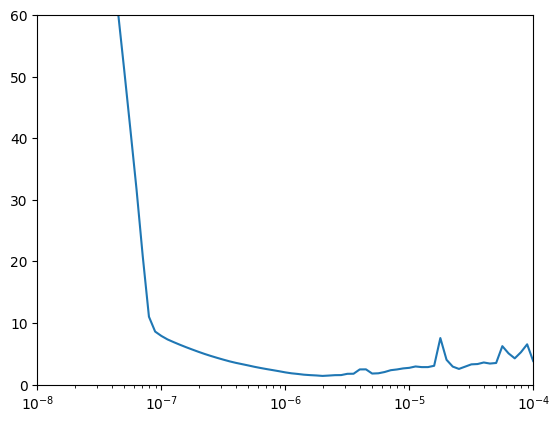

In [37]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

We take the step where the learning rate drops the steepest to train our neural network.

In [39]:
def model_forecast(model, series, window_size):
    """
    Given a model object and a series for it to predict, this function will return the prediction
    """
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [40]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

288/288 [==============================] - 11s 36ms/step


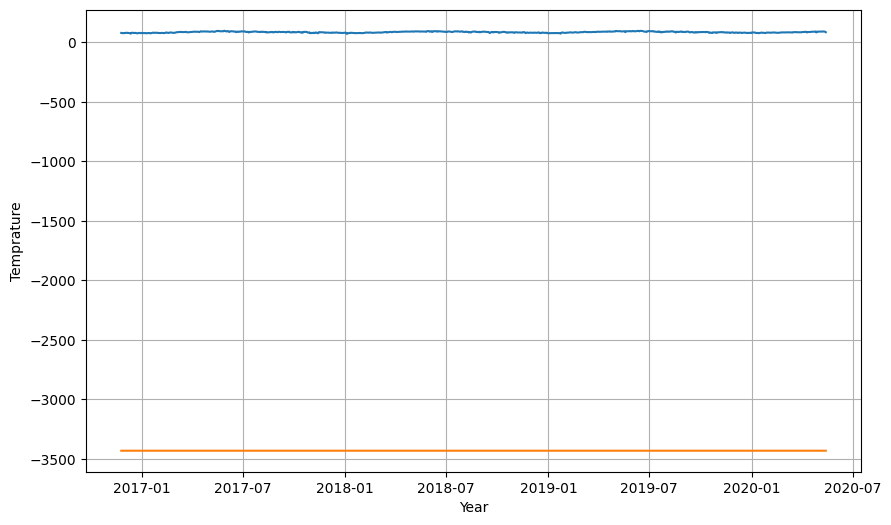

In [41]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [42]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

3516.4124

ValueError: x and y must have same first dimension, but have shapes (300,) and (0,)

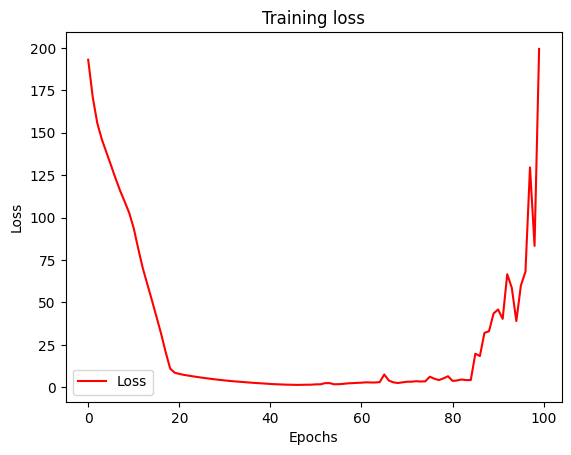

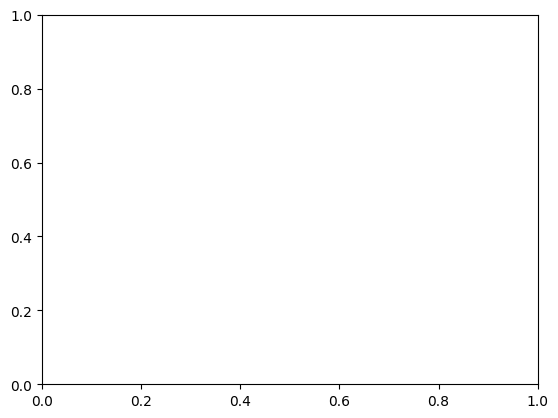

In [44]:
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

# Conclusion

I have demonstrated in this notebook how to use naive forecast, moving average forecast and build a model in CNN and LSTM using tensorflow dataset prepration.

If you find this notebook helpful for you, please upvote!

# References:
1. https://github.com/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Lesson%205.ipynb
2. https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
3. https://stackoverflow.com/questions/19350806/how-to-convert-columns-into-one-datetime-column-in-pandas